Посмотрим на пример старого соревнования от MineThatData:

В датасете содержится информация о 64000 клиентов интернет-магазина, которые совершили покупку в последний раз в течение 12 месяцев перед e-mail рассылкой.

Берём данные о текущем состоянии клиентов и применяем модель. Флага ЦГ или КГ нет.

In [1]:
from typing import List
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylift import pylift
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")

## Файлы
minethatdata_womens_train.csv - файл с обучающей выборкой

minethatdata_womens_test_no_answers.csv - файл с тестовой выборкой

In [3]:
df_train = pd.read_csv('./data/minethatdata_womens_train.csv')
df_test = pd.read_csv('./data/minethatdata_womens_test_no_answers.csv')

In [4]:
print(df_train.shape)
df_train.head()

(21346, 13)


,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0,0,0.0
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0,0,0.0


In [5]:
print(df_test.shape)
df_test.head()

(21347, 10)


,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment
0,61726,2,1) $0 - $100,74.04,0,1,Urban,0,Phone,No E-Mail
1,57540,3,4) $350 - $500,435.14,1,0,Urban,1,Multichannel,Womens E-Mail
2,58265,3,2) $100 - $200,112.96,0,1,Surburban,0,Web,Womens E-Mail
3,46218,8,1) $0 - $100,29.99,1,0,Urban,1,Phone,No E-Mail
4,60139,7,3) $200 - $350,219.81,1,0,Rural,0,Multichannel,No E-Mail


## Описание полей


<b>index</b>: id пользователя <br>
Описание клиента до рассылки (контекст): <br>


<b>recency</b>: количество месяцев с последней покупки<br>
<b>history_Segment</b>: категория (определяется по количеству у.е, потраченных за последний год) <br>
<b>history</b>: количество у.е, потраченных за последний год <br>
<b>mens</b>: индикатор, 1 - клиент купил товары для мужчин за последний год <br>
<b>womens</b>: индикатор, 1 - клиент купил товары для женщин за последний год <br>
<b>zip_Code</b>: региональная категория индексов: Urban, Suburban, или Rural. <br>
<b>newbie</b>: индикатор, 1 - новый клиент (пришел в магазин в первый раз за последние 12 месяцев) <br>
<b>channel</b>:  описывает способы приобретения клиентом товаров за последний год <br>


В этой переменной указано то, к какой группе был отнесен клиент <br>
<b>segment</b>: "Mens E-Mail" / "Womens E-Mail" / "No E-Mail" <br>


Переменные, описывающие клиента в течение 2 недель после получения e-mail: <br>
<b>visit</b>: индикатор, 1 - клиент посетил сайт в последующие 2 недели после рассылки <br>
<b>conversion</b>: индикатор, 1 - клиент купил товары на сайте в последующие 2 недели после рассылки <br>
<b>spend</b>: количество у.е потраченных на покупки в последующие 2 недели <br>

In [6]:
targets = ['visit', 'conversion', 'spend']

## Сравнение групп

В нашем кейсе интересны показатели visit, conversion, spend. Для них и посмотрим различия между ЦГ и КГ. <br>

На обучающей выборке посчитайте для каждой переменной (visit, conversion, spend) следующие метрики <br>

Среднее значение переменной в контрольной группе и в целевой. <br>
Оценку ATE переменной. <br>
Относительное изменение переменной в целевой группе в сравнении с контрольной. <br>


In [7]:
df_train.segment.value_counts()

Womens E-Mail    10709
No E-Mail        10637
Name: segment, dtype: int64

In [8]:
df_train['treatment'] = (df_train.segment == 'Womens E-Mail').astype(int)

In [9]:
report = df_train.groupby('treatment')[targets].mean().reset_index()
report.head()

,treatment,visit,conversion,spend
0,0,0.101720,0.004983,0.583971
1,1,0.148193,0.008498,1.131093


In [10]:
ate = (report.iloc[1, 1:] - report.iloc[0, 1:]).reset_index()
ate.columns = ['variable', 'ate']

relative_change = (report.iloc[1, 1:] / report.iloc[0, 1:]).reset_index()
relative_change.columns = ['variable', 'relative_change']

mean_treated = report.iloc[1, 1:].reset_index()
mean_treated.columns = ['variable', 'mean_treated']

mean_control = report.iloc[0, 1:].reset_index()
mean_control.columns = ['variable', 'mean_control']

In [11]:
report = mean_control.merge(mean_treated).merge(ate).merge(relative_change)
report.head()

,variable,mean_control,mean_treated,ate,relative_change
0,visit,0.101720,0.148193,0.046473,1.456867
1,conversion,0.004983,0.008498,0.003515,1.705437
2,spend,0.583971,1.131093,0.547121,1.936898


In [12]:
# report.to_csv('./data/task1_7.csv', index=False)

## Волатильность метрик
Теперь оценим, насколько посчитанные выше метрики (ATE, relative_change) "шумные".

Это нужно для того, чтобы понять, для каких переменных имеет смысл строить uplift-модель. Если оценка прироста переменной "шумная", вряд ли для получится хорошая uplift-модель.

Для этого предлагается посчитать доверительные интервалы метрик (с уровнем доверия 0.9) и посмотреть на их ширину.

Интервалы можно построить используя bootstrapping. Ниже описан возможный вариант одной итерации бутстреппинга:

* Берем случайную выборку с повторениями размера n_treated из пользователей получивших письмо.

* Берем случайную выборку с повторениями размера n_control из пользователей в контрольной группе.

* Считаем разницу средних значений соответствующей переменной (visit, ...) в группах.

In [13]:
df_treated = df_train[df_train['treatment'] == 1].reset_index().copy()
df_control = df_train[df_train['treatment'] == 0].reset_index().copy()

In [14]:
def plot_ecdf(data):
    x, y = sorted(data), np.arange(1, len(data)+1) / len(data)
    plt.figure()
    plt.scatter(x, y)
    plt.grid()
    plt.show()
    

def bootstrap_interval(target, control, func=lambda t,c: t-c, confidence=.9, n_iter=1000):
    n_target = len(target)
    n_control = len(control)
    
    samples = []
    for i in range(n_iter):
        t = target[np.random.randint(low=0, high=n_target, size=n_target)].mean()
        c = control[np.random.randint(low=0, high=n_control, size=n_control)].mean()
        samples.append(func(t, c))
    
    low = (1 - confidence) / 2
    high = 1 - low
    return np.percentile(samples, 100*low), np.percentile(samples, 100*high)

In [15]:
for target in targets:
    intervals = bootstrap_interval(df_treated[target].values, df_control[target].values)
    print(f'{target} ATE: {intervals}')

visit ATE: (0.03924352616382911, 0.05381704869422773)
conversion ATE: (0.0017259584892440252, 0.005388921077094908)
spend ATE: (0.23060015371301024, 0.8558353532294632)


In [16]:
for target in targets:
    intervals = bootstrap_interval(df_treated[target].values, df_control[target].values, lambda t,c: t/c)
    print(f'{target} relative_change: {intervals}')

visit relative_change: (1.3678456285968468, 1.5482381081673429)
conversion relative_change: (1.2843699837985503, 2.289112024734134)
spend relative_change: (1.3353831820476918, 2.946428877339339)


## Прогнозирование uplift
Видим, что разброс относительного прироста метрик conversion и spend велик. Поэтому шансы получить хорошую uplift-модель для этих метрик мал.

Постройте uplift-модель. Необходимо сделать прогнозы для тестовой выборки и прислать их.

In [17]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result


def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [18]:
df_train = transform_(df_train)

In [19]:
fit_index, val_index = train_test_split(df_train.index, test_size=0.33, random_state=42)

In [20]:
features = [
    'recency',
    'mens',
    'womens',
    'zip_code_Rural', 
    'zip_code_Surburban', 
    'zip_code_Urban',
    'channel_Multichannel', 
    'channel_Phone', 
    'channel_Web',
    'history_segment__label_1', 
    'history_segment__label_2',
    'history_segment__label_3', 
    'history_segment__label_4',
    'history_segment__label_5', 
    'history_segment__label_6',
    'history_segment__label_7',
    
]

In [21]:
upmodel_n0 = pylift.TransformedOutcome(
    df_train.loc[fit_index, features + ['treatment', 'visit']],
    col_treatment='treatment', col_outcome='visit',
    test_size=.33
)

In [22]:
# Трансформированый таргет для схемы с обучением одной модели.

upmodel_n0.transformed_y_train.values

array([1.9979044425817265, 0.0, -0.0, ..., -0.0, 0.0, -0.0], dtype=object)

In [23]:
upmodel_n0.fit()

In [24]:
eval_data = df_train.loc[val_index, features + ['treatment', 'visit']]
eval_data['score'] = upmodel_n0.model.predict(eval_data[features])
eval_data = eval_data[['score', 'treatment', 'visit']]

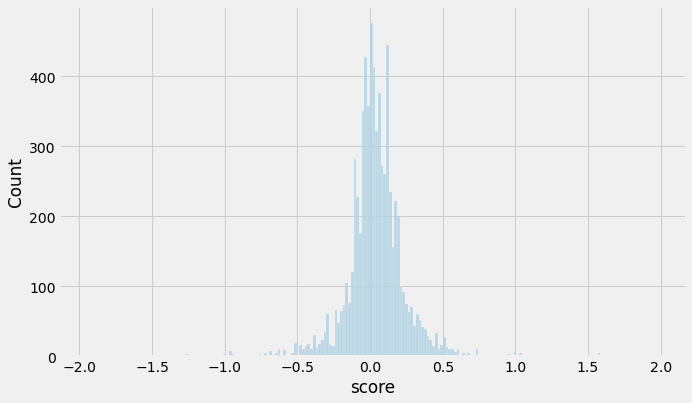

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

## Inference

In [26]:
df_test = transform_(df_test)

In [27]:
test_data = df_test.copy()
test_data['score'] = upmodel_n0.model.predict(df_test[features])
test_data = test_data[['index', 'score']]

In [28]:
# test_data.to_csv('./data/task1_14.csv', index=False)